# DDPM

In [2]:
import copy, os
import logging
from types import SimpleNamespace
from contextlib import nullcontext
from functools import partial


import wandb

import torch
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import OneCycleLR, LinearLR
import torch.nn as nn
from types import SimpleNamespace
from fastprogress import progress_bar, master_bar

from unet import UNet, EMA

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


In [3]:
from diffusers import UNet2DModel

In [4]:
from torch_moving_mnist.utils import *
from torch_moving_mnist.data import MovingMNIST

In [5]:
config = SimpleNamespace(    
    epochs = 1,
    model_name="ddpm_mmnist",
    noise_steps=1000,
    seed = 42,
    batch_size = 64,
    img_size = 40,
    num_frames = 3,
    device = "cuda",
    use_wandb = True,
    do_validation = False,
    fp16 = True,
    num_workers=8,
    train_steps=1000,
    lr = 5e-4,
    normalize=False,
)

In [14]:
load_mmnist = False

if not load_mmnist:
    
    mult = config.img_size // 28
    
    affine_params = dict(
        angle=(-10, 10), # rotation in degrees (min and max values)
        translate=((-mult*10, mult*10), (-mult*10, mult*10)), # translation in pixels x and y
        scale=(.8, 1.3), # scaling in percentage (1.0 = no scaling)
        # shear=(-10, 10), # deformation on the z-plane
        shear=(0,0),
    )

    ds = MovingMNIST(affine_params=affine_params, num_digits=[1,2], 
                     img_size=config.img_size, num_frames=config.num_frames+1,
                     normalize=config.normalize)
    
    def get_batch(bs=config.batch_size, frames=config.num_frames, dim=1, device=config.device):
        b = ds.get_batch(bs).squeeze().to(device)
        return b.split(frames, dim=dim)
else:
    ds = torch.load("mmnist.pt")
    
    def get_batch(bs=config.batch_size, frames=config.num_frames, device=config.device):
        ix = torch.randint(len(ds), (bs,))
        b = ds[ix].squeeze().to(device)
        return b[:,:frames], b[:,[frames]]

In [25]:
ds.save(fname="mmnist_01_40x40.pt", n_batches=1000, bs=128)

Saving dataset


In [16]:
ds[0].shape

torch.Size([4, 1, 40, 40])

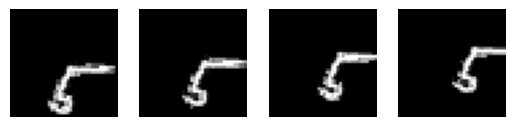

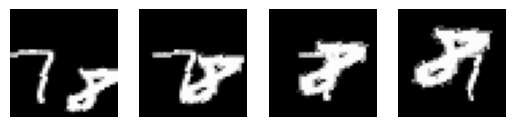

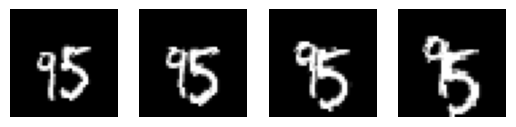

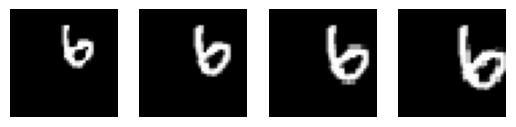

In [24]:
for i in range(4):
    imgs = ds[i]
    show_images(imgs)

In [57]:
x,y = get_batch()

In [58]:
x.shape

torch.Size([64, 3, 64, 64])

In [59]:
x.shape, y.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 1, 64, 64]))

In [60]:
# model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128)).to("cuda")

# t = torch.randint(0, 1000, (24,), device="cuda", dtype=torch.long)
# out = model(torch.rand(24, 1, 32, 32, device="cuda"), t).sample
# loss = out.sum()

# loss.backward()

In [61]:
# jeremy's trick for unet init
from torch.nn import init

from fastcore.foundation import L
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [62]:
class FrameDiffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, c_in=8, c_out=4, use_wandb=False, device="cuda"):

        self.device = torch.device(device)
        self.setup_noise_schedule(noise_steps, beta_start, beta_end)
        self.img_size = img_size
        self.model = UNet2DModel(in_channels=c_in, out_channels=c_out, block_out_channels=(32, 64, 128, 256), norm_num_groups=8).to(self.device)  
        init_ddpm(self.model)
        # self.model = UNet(c_in, c_out).to(device)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.c_in = c_in
        self.use_wandb=use_wandb
        self.fp16 = False
    
    def setup_noise_schedule(self, noise_steps, beta_start, beta_end):
        "DDPM scheduler"
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = torch.linspace(self.beta_start, self.beta_end, self.noise_steps).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,), device=self.device, dtype=torch.long)

    def noise_images(self, x, t):
        "Add noise to images at instant t"
        alpha_hat = self.alpha_hat[t][:, None, None, None]
        Ɛ = torch.randn_like(x)
        return torch.sqrt(alpha_hat) * x + torch.sqrt(1-alpha_hat) * Ɛ, Ɛ
    
    
    def noise_future(self, past_frames, future_frames, zero_past=False):
        noise = torch.randn_like(future_frames)
        if zero_past:
            return torch.cat([torch.zeros_like(past_frames), noise], dim=1)
        else:
            return torch.cat([past_frames, noise], dim=1)
    
    @torch.inference_mode()
    def sample(self, bs=10, use_ema=False):
        logging.info(f"Sampling new images....")
        past_frames, future_frames = get_batch(bs=bs, device=self.device)
        model = self.ema_model if use_ema else self.model
        return self._sample(model, past_frames, future_frames)
    
    @torch.inference_mode()
    def _sample(self, model, past_frames, future_frames):
        model.eval()
        bs = len(past_frames)
        x = torch.randn_like(future_frames)
        for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
            t = (torch.ones(bs) * i).long().to(self.device)
            all_frames = torch.cat([past_frames, x], dim=1)
            predicted_noise = model(all_frames, t).sample
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

        return torch.cat([past_frames, x], dim=1)
    
    def sample_more(self, model, past_frames, n=1):
        "Generate n extra frames one by one"
        bs, f, h, w = past_frames.shape
        future_frames = []
        for _ in progress_bar(range(n), leave=True):
            one_frame = torch.empty(bs, 1, h, w, device=self.device)
            prediction = self._sample(model, past_frames, one_frame)
            past_frames = prediction[:, 1:, ...]
            future_frames.append(prediction[:, -1:, ...]) # last frame
        return torch.cat(future_frames, dim=1)
    
    def log_images(self):
        "Log images to wandb and save them to disk"
        def to_image(img):
            return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())
        sampled_images = self.sample(use_ema=False)
        wandb.log({"sampled_images":     [to_image(img) for img in sampled_images]})
        ema_sampled_images = self.sample(use_ema=True)
        wandb.log({"ema_sampled_images": [to_image(img) for img in ema_sampled_images]})

    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
       
        self.scheduler.step()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        # update EMA model
        self.ema.step_ema(self.ema_model, self.model)
     
        

    def train(self, train_steps, use_wandb=False):
        self.model.train()
        pbar = progress_bar(range(train_steps))
        for i in pbar:
            past_frames, future_frames = get_batch()
            t = self.sample_timesteps(past_frames.shape[0])  # batch size
            x_t, noise = self.noise_images(future_frames, t)
            
            # stack past frames with future random placeholder
            all_frames = torch.cat([past_frames, x_t], dim=1)
            
            # forward
            with torch.autocast("cuda", dtype=torch.float16) if self.fp16 else nullcontext():
                predicted_noise = self.model(all_frames, t).sample
                loss = self.mse(noise, predicted_noise)
            
            # step
            self.train_step(loss)
            if self.use_wandb:
                wandb.log({"train_mse": loss.item(),
                           "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"MSE={loss.item():2.3f}"
            
            if i % 1000 == 0:
                self.log_images()

    def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))

    def save_model(self, model_name, use_wandb=False, epoch=-1):
        "Save model locally and on wandb"
        torch.save(self.model.state_dict(), os.path.join("models", model_name, f"ckpt.pt"))
        torch.save(self.ema_model.state_dict(), os.path.join("models", model_name, f"ema_ckpt.pt"))
        torch.save(self.optimizer.state_dict(), os.path.join("models", model_name, f"optim.pt"))
        if use_wandb:
            at = wandb.Artifact("model", type="model", description="Model weights for DDPM conditional", metadata={"epoch": epoch})
            at.add_dir(os.path.join("models", model_name))
            wandb.log_artifact(at)

    def prepare(self, optimizer, scheduler):
        self.optimizer = optimizer(self.model.parameters())
        self.scheduler = scheduler(self.optimizer)
        self.scaler = torch.cuda.amp.GradScaler()
        self.mse = nn.MSELoss(reduction="sum")
        self.ema = EMA(0.995)

    def fit(self, args):
        self.train(args.train_steps, use_wandb=args.use_wandb)

In [63]:
diffuser = FrameDiffusion(c_in=4, c_out=1, noise_steps=config.noise_steps, device=config.device, use_wandb=True)

In [64]:
config.fp16 = True
config.noise_steps = 1000
config.train_steps = 10_000

## Train

In [65]:
optimizer = partial(Adam, eps=1e-5)
scheduler = partial(OneCycleLR, max_lr=config.lr, total_steps=config.train_steps)

In [66]:
diffuser.prepare(optimizer, scheduler)

In [ ]:
with wandb.init(project="ddpm_mmnist", group="train", tags=["fp16", "big"], config=config) if config.use_wandb else nullcontext():
    diffuser.fit(config)

03:35:26 - INFO: Sampling new images....


03:35:57 - INFO: Sampling new images....


03:43:38 - INFO: Sampling new images....


03:44:09 - INFO: Sampling new images....


03:51:51 - INFO: Sampling new images....


03:52:21 - INFO: Sampling new images....


04:00:06 - INFO: Sampling new images....


04:00:37 - INFO: Sampling new images....


04:08:22 - INFO: Sampling new images....


04:08:53 - INFO: Sampling new images....


04:16:38 - INFO: Sampling new images....


04:17:09 - INFO: Sampling new images....


04:24:54 - INFO: Sampling new images....


04:25:25 - INFO: Sampling new images....


04:33:10 - INFO: Sampling new images....


04:33:41 - INFO: Sampling new images....


04:41:26 - INFO: Sampling new images....


04:41:57 - INFO: Sampling new images....


04:49:42 - INFO: Sampling new images....


04:50:12 - INFO: Sampling new images....


In [ ]:
diffuser.save_model("ddpm_big")

In [ ]:
!sudo poweroff

## Sample

load a model

In [23]:
import numpy as np

In [24]:
# diffuser.load("models/ddpm_simple")

In [25]:
samples = diffuser.sample(bs=8)

10:01:48 - INFO: Sampling new images....


In [26]:
def to_image(img):
    return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())

In [27]:
imgs = [to_image(s) for s in samples]

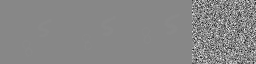

In [28]:
imgs[2].image

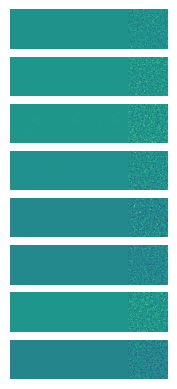

In [29]:
show_images([im.image for im in imgs], nrows=len(imgs))

autoregression

In [30]:
past_frames, future_frames = get_batch(bs=32)

In [31]:
past_frames.shape

torch.Size([32, 3, 64, 64])

In [32]:
past_frames_imgs = [to_image(s) for s in past_frames]

In [33]:
# show_images([f.image for f in past_frames_imgs], nrows=len(past_frames_imgs))

In [34]:
model = diffuser.ema_model

In [35]:
future_frames = diffuser.sample_more(model, past_frames, n=5)

In [36]:
future_frames.shape

torch.Size([32, 5, 64, 64])

In [37]:
future_frames_imgs = [to_image(s) for s in future_frames]

In [38]:
# show_images([f.image for f in future_frames_imgs], nrows=len(future_frames_imgs))

In [39]:
def create_predictions_table(past_frames, future_frames):
    past_frames_imgs = [to_image(s) for s in past_frames]
    predictions = [to_image(s) for s in future_frames]
    
    table = wandb.Table(columns=["past", "preds"])
    for pf, pred in zip(past_frames_imgs, predictions):
        table.add_data(pf, pred)
    return table

In [40]:
t = create_predictions_table(past_frames, future_frames)

In [41]:
with wandb.init(project="ddpm_mmnist", group="log_preds", config=config) if config.use_wandb else nullcontext():
    wandb.log({"ema_preds_table":t})